In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 5.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Coding/Afnan/Models

/content/gdrive/MyDrive/Coding/Afnan/Models


In [ ]:
ls

Bert.ipynb     CNN.ipynb   LSTM.ipynb               model.png
Bi-LSTM.ipynb  Embedding/  LSTM_With_BI-LSTM.ipynb  preprocessed.csv


## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as seaborn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os

from transformers import AutoTokenizer, TFAutoModel 
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [ ]:
data = pd.read_csv('preprocessed.csv')
data = data[['Text','Compartive']]
data.head()

,Text,Compartive
0,يقولك تطبيقات ابل افضل سامسونغ اعرف دفيع واهبل...,1
1,معليش لازم نكون نفسك نصير سبايك داءما حقين ا...,1
2,تر ابل افضل شركات الجولات الاستخدام عشان الن...,1
3,وجهه نظري ابل افضل ناحيه الاستخدام العام الان...,1
4,جهاز متصل بالنت فاهو جهاز امن بس الحق ينقال...,1


In [ ]:
# loading Pretrained Tokenizer
tokenizer = AutoTokenizer.from_pretrained('CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment')

#### Let's go the some basic operations such as convert text into token and ids.

In [ ]:
sample_text = "بالنسبة لي انا احبهم جميعا ابل و سامسونج"
# tokenize split text into words
tokens = tokenizer.tokenize(sample_text)
tokens

['بالنسبة', 'لي', 'انا', 'احبه', '##م', 'جميعا', 'ابل', 'و', 'سامسونج']

In [ ]:
# split string into each token id
ids = tokenizer.encode(sample_text,max_length=20,padding='max_length')
ids

[2,
 4952,
 2134,
 2315,
 10032,
 1015,
 5144,
 21331,
 415,
 12653,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(ids)
tokens

['[CLS]',
 'بالنسبة',
 'لي',
 'انا',
 'احبه',
 '##م',
 'جميعا',
 'ابل',
 'و',
 'سامسونج',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
string = tokenizer.convert_tokens_to_string(tokens)
string

'[CLS] بالنسبة لي انا احبهم جميعا ابل و سامسونج [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

### from previous cells we can see that the tokenizer puts `[CLS]` at the beginning and `[SEP]` and the End of Each Sentence.
### Then Padding the sentence to maximum length with `[PAD]` Token 

### Exmaple of An Input ?

## `[CLS]` Sentence A tuh `[PAD]` `[PAD]` `[SEP]` 

### Special Tokens

### `[UNK]` is used to tell the model that there is a word or something , which is not important to the output, if the word is not in the dictionary we have chosen then we say we have no valid representation for this word

In [ ]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [ ]:
# bert model receives a fixed length of sentence as input , usually the maximum length 
# is shorter than this max length , so we have to add paddings (Empty Tokens) to the sentence  
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
# cls is a token that putted at the first of each sentence
tokenizer.cls_token , tokenizer.cls_token_id

('[CLS]', 2)

In [ ]:
# seperate Token is putted at the end of every sentence
tokenizer.sep_token , tokenizer.sep_token_id

('[SEP]', 3)

In [ ]:
# maximum length of every sentence
max_len = 35

In [ ]:
# splitting our data into training and testing with 15% for testing
df_train , df_test = train_test_split(data,test_size=.15) 
df_train.shape, df_test.shape

((479, 2), (85, 2))

In [ ]:
# convert training data into token ids and attention masks
x_train = tokenizer(
    # test that needs to be convert
    text=df_train['Text'].tolist(),
    # add special tokens such as CLS at the start of the sentence and SEP at the end of the sentence
    add_special_tokens=True,
    # specifiy the maximum length 
    max_length=max_len,
    # truncate the sentence to this maximum length
    truncation=True,
    # apply padding > fill the sentence shorter than maximum length with 00
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    # return attention masks 
    return_attention_mask=True,
    verbose=True
)

In [ ]:
x_train.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
x_test = tokenizer(
    text=df_test['Text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

### Tokenizer returns a list of `attention_mask` arays , this is because we don't want the model to get confused by additional padding tokens: the attention mask allows the model to ignore the padded parts of the input text

In [ ]:
# get the base model which is a Arabic Pretrained Bert
base_model = TFAutoModel.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment")

Some layers from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment were not used when initializing TFBertModel: ['dropout_113', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### The input of the model is `input_ids` and `attention_mask` to pass to the bert

In [ ]:
# Input allows us to build a Keras model just by knowing the inputs and outputs of the model.
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
input_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

## BERT outputs 2 things: `last_hidden_state` and `pooler_output` .

`last_hidden_state` contains the hidden representations for each token in each sequence of the batch. So the size is (batch_size, seq_len, hidden_size).

`pooler_output` contains a "representation" of each sequence in the batch, and is of size (batch_size, hidden_size)

In the forward pass, they use outputs[1], meaning the output of `the pooler layer` (whose weights were pretrained on the next sentence classification task). This pooler layer takes the final hidden representation of the [CLS] token (this is a vector of size 768),

In [ ]:
base_model(input_ids,attention_mask=input_masks)['last_hidden_state'].shape

TensorShape([None, 35, 768])

In [ ]:
base_model(input_ids,attention_mask=input_masks)['pooler_output'].shape

TensorShape([None, 768])

In [ ]:
# getting the pooler_output of base model "Bert"
net = base_model(input_ids,attention_mask=input_masks)[1]
# pass the output of pooler layer into fully connected layer its neurons count 64 
net = Dense(64, activation='relu')(net)
# pass the output of fullyconnected to dropout to reduce over fitting
net = Dropout(.4)(net)
net = Dense(32,activation='relu')(net)
y = Dense(1,activation='sigmoid')(net)

In [ ]:
# define the model with its input and output 
model = Model(inputs=[input_ids,input_masks], outputs=y)

### Reference to Adam :: https://www.geeksforgeeks.org/intuition-of-adam-optimizer/

### Tutorial :: 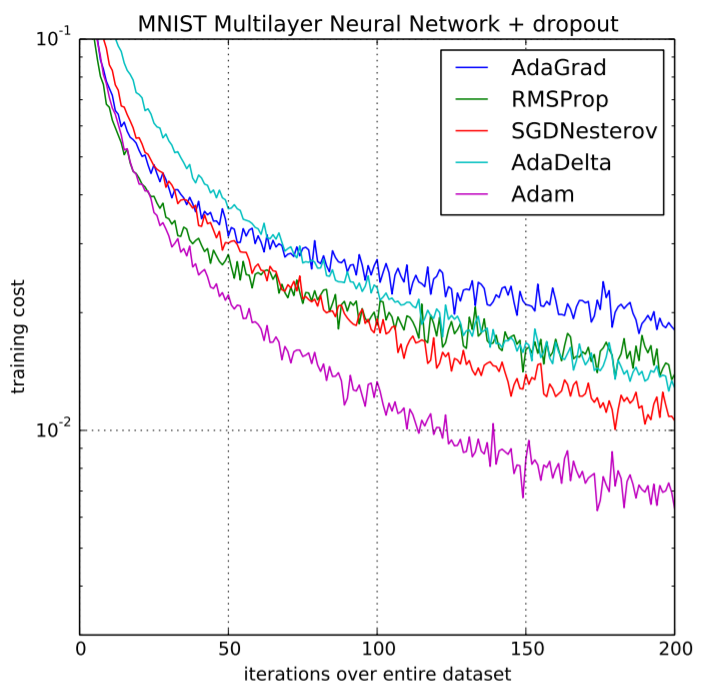

In [ ]:
# adam optimizer is used to accelerate the training.
adam = Adam(
    learning_rate=5e-05,
    # A small constant for numerical stability.
    epsilon= 1e-08,
    # the gradient of each weight is individually clipped so that its norm is no higher than this value.
    clipnorm=1.0
)

In [ ]:
model.compile(optimizer=adam,loss='binary_crossentropy',metrics='accuracy')
# loss indicates to penalty for a bad prediction,
# its number indicating how bad the model's prediction is on a single example.
#if the model is prefect then the loss = 0

In [ ]:
# Stop training when a monitored metric has stopped improving.
  # monitor > Quantity to be monitored
  # patience > Number of epochs with no improvement after which training will be stopped
early_stop = EarlyStopping(monitor='val_accuracy',patience=2,mode='max')

# os.getcwd is used to get path of current direcotry then pass it to join function that used to joining
# two file pathes 
file_path = os.path.join(os.getcwd(),"checkPoints/BERT/model.h5")
check_point = ModelCheckpoint(filepath=file_path,
                              # monitor is the metrics that we want to optimize
                              monitor='val_accuracy',
                              # mode tells that we look for maximize this monitor
                              mode='max',
                              # ensure that the lasest best model (accroding to the metrics) will not
                              # change
                              save_best_only=True,
                              save_wrights_only=True,
                              #set logs notification during model training
                              verbose=1)

In [ ]:
history = model.fit(
    # as I mentioned previously the model takes two input input_ids for the words and attentio_mask
    x={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']},
    # target value to guide the model 
    y = df_train['Compartive'],
    validation_data=({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']},
                     df_test['Compartive']),
    epochs=5,
    batch_size=32,
    callbacks=[early_stop,check_point]               
)

Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.8559
Epoch 1: val_accuracy improved from -inf to 0.91765, saving model to /content/gdrive/MyDrive/Coding/Afnan/Models/checkPoints/BERT/model.h5
15/15 [==============================] - 13s 888ms/step - loss: 0.0512 - accuracy: 0.8559 - val_loss: 0.4119 - val_accuracy: 0.9176
Epoch 2/5
15/15 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.8559
Epoch 2: val_accuracy did not improve from 0.91765
15/15 [==============================] - 6s 371ms/step - loss: 0.0535 - accuracy: 0.8559 - val_loss: 0.4051 - val_accuracy: 0.9176
Epoch 3/5
15/15 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.8559
Epoch 3: val_accuracy did not improve from 0.91765
15/15 [==============================] - 6s 380ms/step - loss: 0.0222 - accuracy: 0.8559 - val_loss: 0.4312 - val_accuracy: 0.9176


In [ ]:
def plot_graph(history,string):
  plt.plot(history.history[string],label="Trainging " + string)
  plt.plot(history.history["val_"+string], label='Validation '+ string)
  plt.legend()
  plt.xlabel("epochs")
  plt.ylabel(string)
  plt.title(string+ " VS Epochs")
  plt.show()

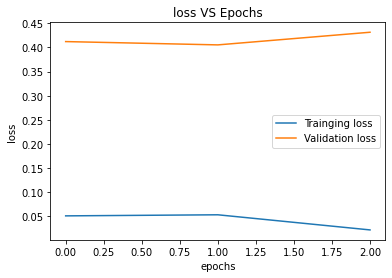

In [ ]:
plot_graph(history,'loss')

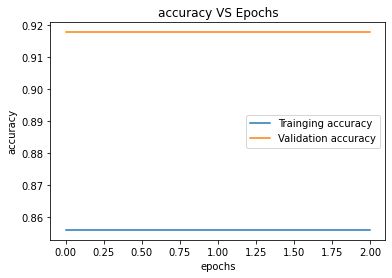

In [ ]:
plot_graph(history,'accuracy')

In [ ]:
print("Model Performance on Test set")
result = model.evaluate(x={"input_ids":x_test['input_ids'],"attention_mask":x_test['attention_mask']},
                        y=df_test['Compartive'])
print(dict(zip(model.metrics_names, result)))

Model Performance on Test set
3/3 [==============================] - 0s 113ms/step - loss: 0.4312 - accuracy: 0.9176
{'loss': 0.43124210834503174, 'accuracy': 0.9176470637321472}


In [ ]:
y_predict = model.predict(x={"input_ids":x_test['input_ids'],"attention_mask":x_test['attention_mask']})
y_predict[:10]

3/3 [==============================] - 0s 94ms/step


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
print(f"Model Accuracy on Test Set is {accuracy_score(df_test['Compartive'],y_predict)}")

Model Accuracy on Test Set is 0.9176470588235294


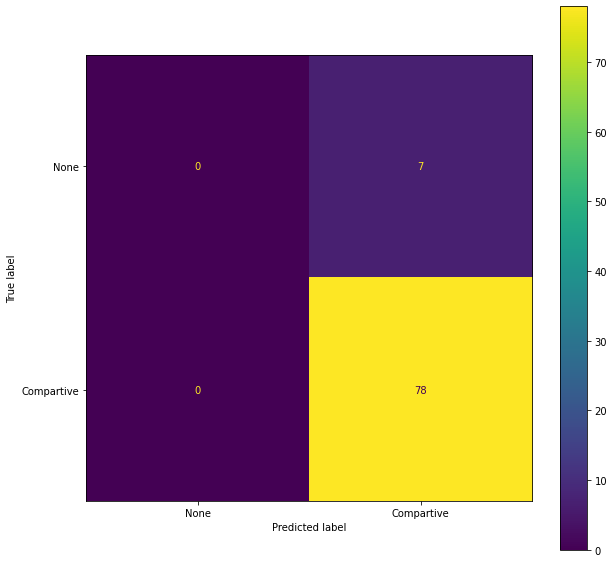

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
confusion = confusion_matrix(df_test['Compartive'],y_predict)
graph = ConfusionMatrixDisplay(confusion,display_labels=['None','Compartive'])
graph.plot(ax=ax)
plt.show()

In [ ]:
class_report = classification_report(df_test['Compartive'],y_predict)
print(class_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.92      1.00      0.96        78

    accuracy                           0.92        85
   macro avg       0.46      0.50      0.48        85
weighted avg       0.84      0.92      0.88        85



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
